<header style="padding: 4em 0 0em 0">
    <img src="http://brentyi.github.io/filestore/ai4all_logo.svg" style="width: 30em; height: auto; margin: 0;" />
    <h3 style="margin: 1em 0 0 0;">
        <strong>Computer Vision II</strong>
        <span style="color: #777">
        &nbsp;&blacksquare;&nbsp;
        Robotics, Summer 2020</span>
    </h3>
</header>

<hr style="border-top: 0.4em solid #eee;" />

In this notebook, we'll take a look at different ways of actually processing and manipulating images.
We'll study **image histograms**, then implement three operations: **crop**, **resize**, and **rotate**.

This will be done in RGB, but do still keep other color representations in mind &mdash; they'll come in handy soon!

<hr style="border-top: 0.4em solid #eee;" />

Before we get started, let's import some stuff and load a test image:

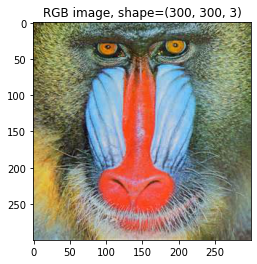

In [1]:
import numpy as np
from cv_helpers import load_image, visualize_rgb
import matplotlib.pyplot as plt

rgb_image = load_image("cv_assets/baboon.jpg")
visualize_rgb("RGB image", rgb_image)

## 1. Image Histograms

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Histogram Implementation</div>

Using the `np.histogram()` function, implement the `histogram_single_channel()` function!

This should only be one line, and you'll need to use the `a`, `bins`, and `range` arguments.

In [2]:
def histogram_single_channel(image, bins):
    """Given a single-channel image (2D array) and bin count, compute a
    corresponding image histogram.
    
    Args:
        image (np.ndarray): Input image. Shape should be (rows, cols).
        bins (int): Number of bins in our image histogram.
    Returns:
        np.ndarray: 1D NumPy array containing our histogram values.
    """
    # Validate input
    assert isinstance(image, np.ndarray), "Input should be a NumPy array!"
    assert len(image.shape) == 2, "Shape of image should be (rows, cols)"
    assert np.min(image) >= 0.0, "Intensities should be between 0.0 and 1.0!"
    assert np.max(image) <= 1.0, "Intensities should be between 0.0 and 1.0!"

    # Get image histogram and bin edges
    # fmt: off
    hist, bin_edges = np.histogram(image, bins=bins, range=(0.0, 1.0)) # ~~DELETE RHS~~
    # fmt: on

    # Return histogram
    return hist


assert histogram_single_channel(np.zeros((10, 10)), 200)[0] == 100
assert histogram_single_channel(np.ones((10, 10)), 200)[-1] == 100

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Histogram Analysis</div>

Using the `load_image(path)` function, load the images located at `"cv_assets/iguana.png"` and `"cv_assets/waldo.jpg"`.

Then, call `visualize_rgb_histogram(rgb_image)` on them to visualize R, G, and B histograms for each image.

- What do you notice about the histograms for the iguana image?
- What do you notice about the histograms for the Waldo image?

> *Your response here!*



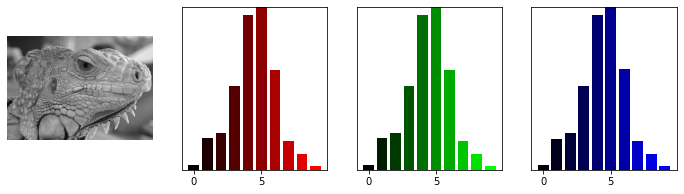

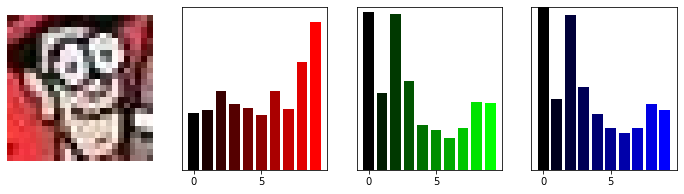

In [3]:
def visualize_rgb_histograms(rgb_image):
    """Given an RGB image, visualize the histogram for each channel.
    
    Args:
        rgb_image (np.ndarray): Image to visualize histograms for.
    """
    bins = 10

    # Compute histograms
    histograms = []
    for i in range(3):
        histograms.append(histogram_single_channel(rgb_image[:, :, i], bins))

    # Create 4 side-by-side plots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

    # Display the image
    axes[0].imshow(rgb_image)
    axes[0].axis("off")

    # Display each histogram
    for i in range(len(histograms)):
        # Add colored bar graph
        colors = np.zeros((bins, 3))
        colors[:, i] = np.linspace(0.0, 1.0, bins)
        axes[i + 1].bar(
            range(bins), histograms[i], color=colors,
        )

        # Match all y-axis ranges
        axes[i + 1].set_ylim(0, np.max(histograms))
        axes[i + 1].set_yticks([])
    plt.show()


# Visualize histograms for two images: a grayscale iguana and Waldo
# ~~START DELETE~~
visualize_rgb_histograms(load_image("cv_assets/iguana.png"))
visualize_rgb_histograms(load_image("cv_assets/waldo.jpg"))
# ~~END DELETE~~

## 2. Cropping

One of the most common operations we perform when working with images is rectangular **cropping**, or the action of removing unwanted outer areas of an image:

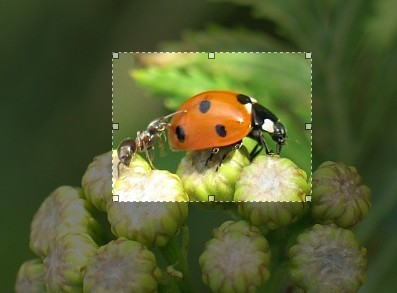

First, let's visualize the image that we loaded:

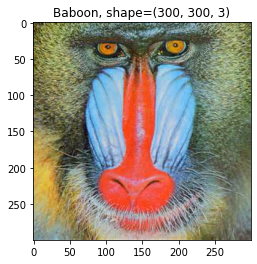

In [4]:
visualize_rgb("Baboon", rgb_image)

Next, take a look at this code we've written to crop out everything but the eyes of our baboon from above:

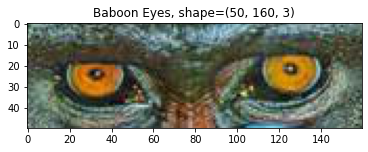

In [5]:
visualize_rgb("Baboon Eyes", rgb_image[10:60, 70:230, :])

Notice that this can be equivalently written as:

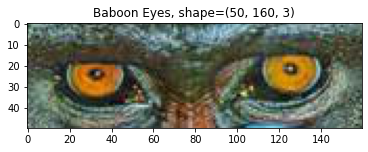

In [6]:
visualize_rgb("Baboon Eyes", rgb_image[10:60, 70:-70, :])

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Cropping</div>

Try cropping the image for yourself in the cell below; see if you can pull out a 100x100 square from each corner of `rgb_image`: the top left, top right, bottom left, and bottom right.


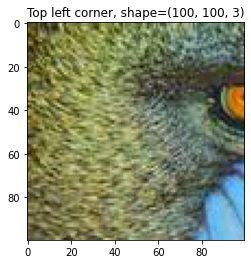

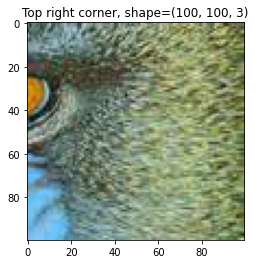

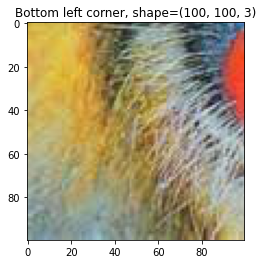

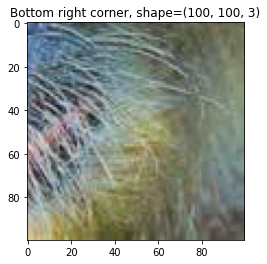

In [7]:
top_left_corner = rgb_image[:100, :100, :]  # ~~DELETE RHS~~
top_right_corner = rgb_image[:100, -100:, :]  # ~~DELETE RHS~~
bottom_left_corner = rgb_image[-100:, :100, :]  # ~~DELETE RHS~~
bottom_right_corner = rgb_image[-100:, -100:, :]  # ~~DELETE RHS~~

visualize_rgb("Top left corner", top_left_corner)
visualize_rgb("Top right corner", top_right_corner)
visualize_rgb("Bottom left corner", bottom_left_corner)
visualize_rgb("Bottom right corner", bottom_right_corner)

### 3. Resizing

Let's try another commonly used operation: image resizing!

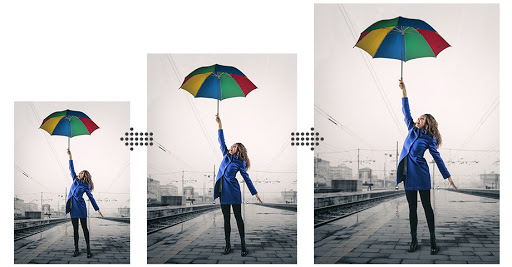

At a high level, image resizing should go something like this:

1. We create an (initially empty) output array of the desired size, `output_image`
2. We iterate over each pixel position `(i,j)` in the output image
    - For each output pixel, we compute a corresponding input pixel `(input_i, input_j)`
    - We assign `output_image[i, j, :]` to `input_image[input_i, input_j, :]`
3. We return the resized output image

We want `input_i` and `input_j` to increase proportionally with `i` and `j` respectively:

- `input_i` can be computed as `int(i * row_scale_factor)`
- `input_j` can be computed as `int(j * col_scale_factor)`

...where `int()` is a Python operation takes a float and rounds it down to the nearest integer, and `row_scale_factor` and `col_scale_factor` are constants computed from the image input/output sizes.

Try to figure out what `row_scale_factor` and `col_scale_factor` should be, then implement this algorithm in the skeleton below!

In [8]:
def resize_image(input_image, output_rows, output_cols):
    """Resize an image using the nearest neighbor method.
    
    Args:
        input_image (np.ndarray): RGB image stored as an array, with shape
            `(input_rows, input_cols, 3)`.
        output_rows (int): Number of rows in our desired output image.
        output_cols (int): Number of columns in our desired output image.

    Returns:
        np.ndarray: Resized image, with shape `(output_rows, output_cols, 3)`.
    """
    input_rows, input_cols, channels = input_image.shape
    assert channels == 3

    # 1. Create the resized output image
    output_image = np.zeros(shape=(output_rows, output_cols, 3))

    # 2. Populate the `output_image` array using values from `input_image`
    #    > This should require two nested for loops!
    # ~~START DELETE~~
    for i in range(output_rows):
        for j in range(output_cols):
            input_i = int(i / output_rows * input_rows)
            input_j = int(j / output_cols * input_cols)
            output_image[i, j, :] = input_image[input_i, input_j, :]
    # ~~END DELETE~~

    # 3. Return the output image
    return output_image

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Resizing</div>

Run the cells below to test out your image resizing algorithm!

When you downsize the baboon to 16x16, you should expect an output that looks something like this:

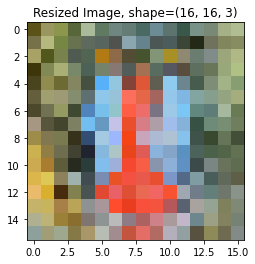

When you stretch it horizontally to 50x400, you should get:

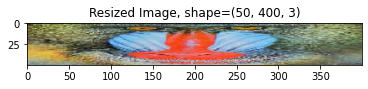

**Question:** in the resize algorithm we describe above, the output is populated by iterating over the indices of the output image. Could we implement image resizing by iterating over the indices of the input image instead? How do the two approaches compare?

> *Your response here!*

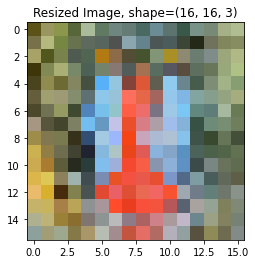

In [9]:
# Visualize downsizing an image
visualize_rgb("Resized Image", resize_image(rgb_image, 16, 16))

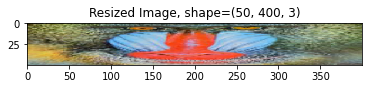

In [10]:
# Visualize an image that's been stretched horizontally
visualize_rgb("Resized Image", resize_image(rgb_image, 50, 400))

### 4. Image Rotation

One more operation that you can try implementing is **image rotation**. This is part of a real interview question that we've encountered for actual computer vision jobs (notably at Facebook), and we expect it to require quite a bit more thinking.

#### a) Rotating 2D coordinates

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Implementation</div>

Before we start thinking about rotating full images, let's start by taking a look at rotating `(x, y)` coordinates:

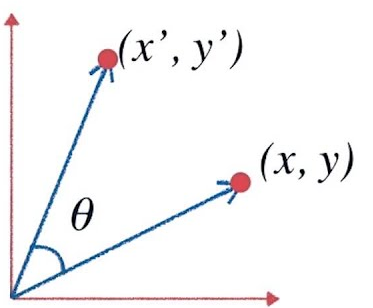

Using `np.cos()` and `np.sin()`, implement the `rotate2d` function below to compute $(x', y')$ from $(x, y)$!

If you've taken a geometry course that's covered sines and cosines, there's a good chance you can derive the equations yourself. Alternatively, you can also [find them online](https://academo.org/demos/rotation-about-point/).

In [11]:
def rotate2d(point, theta):
    """Rotate a 2D coordinate by some angle theta.
    
    Args:
        point (np.ndarray): A 1D NumPy array containing two values: an x and y coordinate.
        theta (float): An theta to rotate by, in radians.
        
    Returns:
        np.ndarray: A 1D NumPy array containing your rotated x and y values.
    """
    assert point.shape == (2,)
    assert isinstance(theta, float)

    # Reminder: np.cos() and np.sin() will be useful here!
    # ~~START DELETE~~
    x, y = point
    x_prime = x * np.cos(theta) - y * np.sin(theta)
    y_prime = y * np.cos(theta) + x * np.sin(theta)
    return np.array([x_prime, y_prime])
    # ~~END DELETE~~


# Test your rotate2d implementation!
assert rotate2d(np.array([1.0, 0.0]), 0.0).shape == (
    2,
), "Output shape incorrect!"
assert np.allclose(
    rotate2d(np.array([1.0, 0.0]), 0.0), np.array([1.0, 0.0])
), ""
assert np.allclose(
    rotate2d(np.array([1.0, 0.0]), np.pi / 2.0), np.array([0.0, 1.0])
), ""

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Visualization &amp; Analysis</div>

Run the cell below to visualize a point as it's rotated around the origin by a set of evenly-spaced angles! You should see 30 points arranged in a circle.

1. Find the documentation for `plt.scatter()`. What are the first two arguments?
2. What does `points[:, 0]` evaluate to? What about `points[:, 1]`?
3. Describe in words what the `points` array contains after the 10th iteration of the for loop.
4. Our function currently only rotates input points around the origin (0,0). Using the same `rotate2d` function, how could we rotate the point around a center that wasn't at the origin? **You'll need to do this when you implement image rotation below!**

> *Your response here!*

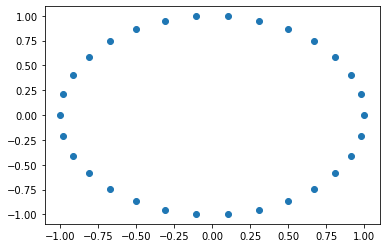

In [12]:
# Visualize a point being rotated around the origin
# We'll use the matplotlib library for this!
import matplotlib.pyplot as plt

points = np.zeros((30, 2))
for i in range(30):
    points[i, :] = rotate2d(np.array([1.0, 0.0]), i / 30.0 * (2 * np.pi))

plt.scatter(points[:, 0], points[:, 1])
plt.show()

#### b) Rotate Image
<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Implementation</div>

Finally, use what you've learned about 2D rotations to create and implement a `rotate_image(input_image, theta)` function!

We won't be providing any starter code for this one, but here's a docstring description to guide you:

```
    """Rotate an image by some angle theta.
    
    Args:
        input_image (np.ndarray): RGB image stored as an array, with shape
            `(input_rows, input_cols, 3)`.
        theta (float): Angle to rotate our image by, in radians.

    Returns:
        np.ndarray: Rotated image, with the same shape as the input.
    """
```


For an input angle of $\pi/4$ (45 degrees), the expected output is:

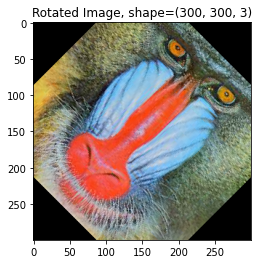

(in our example, we treat a positive angle as clockwise -- but feel free to use whatever convention you want)

**Hints:**
- We recommend basing your code off your `resize_image()` implementation, and applying the same general approach as before. Iterate over each pixel of an output image `(i, j)`, then fill in a color from a corresponding input pixel `(input_i, input_j)`. In this case, note that the output and input images should be the same size.
- If you run into an output pixel whose corresponding input coordinates `input_i` and `input_j` that are invalid, you can just ignore that pixel or set it to black.
- In our expected output above, we're rotating each coordinate around the center of the image, not the origin. (the origin is located at the top left)

In [13]:
# ~~START DELETE~~
def rotate_image(input_image, theta):
    """Rotate an image by some angle theta.
    
    Args:
        input_image (np.ndarray): RGB image stored as an array, with shape
            `(input_rows, input_cols, 3)`.
        theta (float): Angle to rotate our image by, in radians.

    Returns:
        (np.ndarray): Rotated image, with the same shape as the input.
    """
    input_rows, input_cols, channels = input_image.shape
    assert channels == 3

    # 1. Create an output image with the same shape as the input
    output_image = np.zeros_like(input_image)

    # 2. Populate the `output_image` array using values from `input_image`
    #    > This should require two nested for loops!
    #    > We can ignore any values of (input_i, input_j) that fall outside of
    #      the input image
    center = np.array([input_rows // 2, input_cols // 2])
    for i in range(input_rows):
        for j in range(input_cols):
            input_i, input_j = (
                rotate2d(np.array([i, j]) - center, theta) + center
            )
            input_i = int(input_i)
            input_j = int(input_j)
            if 0 <= input_i < input_rows and 0 <= input_j < input_cols:
                output_image[i, j, :] = input_image[input_i, input_j, :]

    # 3. Return the output image
    return output_image
# ~~END DELETE~~

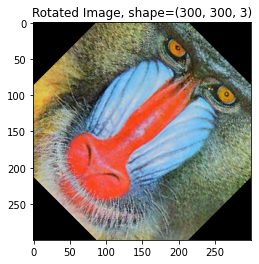

In [14]:
visualize_rgb("Rotated Image", rotate_image(rgb_image, np.pi / 4.0))